In [1]:
import tensorflow as tf
from keras import datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
beta = 0.5
cutmix_prob = 1.0
num_classes = 100
batch_size = 6
r = 0.7

In [3]:
def train_augment(image,label):
  image = tf.image.resize_with_crop_or_pad(image, 36, 36) 
  image = tf.image.random_crop(image, size=[32, 32, 3])
  image = tf.image.random_flip_left_right(image) 
  image = tf.cast(image, dtype=tf.float32)
  label = tf.cast(label, dtype=tf.float32)
  return image,label

In [4]:
def rand_bbox(size, lam):

    W = size[1]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()

169017344/169001437 [==============================] - 3s 0us/step


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(train_augment).batch(batch_size)#.shuffle(512)

In [7]:
# cutmix
for image, target in train_dataset:       
  if beta > 0 and r < cutmix_prob:
      lam = np.random.beta(beta, beta) 
      rand_index = tf.random.shuffle(tf.range(len(target))) 
      target_a = target
      target_b = tf.gather(target, rand_index) 
      bbx1, bby1, bbx2, bby2 = rand_bbox(image.shape, lam)       
      image_a = image
      image_b = tf.gather(image, rand_index)
      mask = np.ones_like(image)
      mask[:, bbx1:bbx2, bby1:bby2, :] = 0
      image_cutmix = tf.math.multiply(image_a,mask) + tf.math.multiply(image_b, (abs(1.-mask)))

  break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

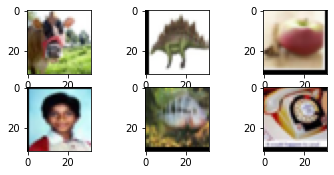

In [9]:
# Original images
import matplotlib.pyplot as plt

for i in range(batch_size):
	plt.subplot(330 + 1 + i)
	plt.imshow(image[i]/255.)
plt.show()

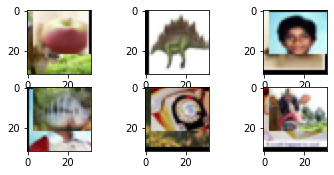

In [10]:
# Cutmix images
import matplotlib.pyplot as plt

for i in range(batch_size):
	plt.subplot(330 + 1 + i)
	plt.imshow(image_cutmix[i]/255.)
plt.show()